##### Copyright 2020 The TensorFlow Authors.

## Setup

Import necessary modules and dependencies.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importando categoria de sons

In [2]:

# data_dir = pathlib.Path('./dataset/normalized')
data_dir = pathlib.Path('./dataset/mono')

Check basic statistics about the dataset.

In [3]:
categories = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Categorias:', categories)

Categorias: ['hihat' 'kick' 'noise' 'snare']


Extract the audio files into a list and shuffle it.

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 272
Number of examples per label: 53
Example file tensor: tf.Tensor(b'dataset/mono/snare/real-soft-snare.wav', shape=(), dtype=string)


2022-03-01 22:51:31.747751: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Divida os arquivos em conjuntos de treinamento, validação e teste usando uma proporção de 80:10:10, respectivamente.

In [5]:
import math

train_files_limit = math.trunc(num_samples * 0.8)
val_files_limit = math.trunc(num_samples * 0.1)
test_files_limit = math.trunc(num_samples * 0.1)

train_files = filenames[:train_files_limit]
val_files = filenames[train_files_limit: train_files_limit + val_files_limit]
test_files = filenames[-test_files_limit:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 217
Validation set size 27
Test set size 27


## Lendo arquivos de audio e categorias

O arquivo de áudio será inicialmente lido como um arquivo binário, que você desejará converter em um tensor numérico.

Para carregar um arquivo de áudio, você usará tf.audio.decode_wav, que retorna o áudio codificado em WAV como um Tensor e a taxa de amostragem.

Um arquivo WAV contém dados de séries temporais com um número definido de amostras por segundo. Cada amostra representa a amplitude do sinal de áudio naquele momento específico. Em um sistema de 16 bits, os valores variam de -32768 a 32767. A taxa de amostragem para este conjunto de dados é de 16kHz. Observe que tf.audio.decode_wav normalizará os valores para o intervalo [-1.0, 1.0].

In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=-1)
#   return tf.squeeze(audio, axis=-1)
  return audio

The label for each WAV file is its parent directory.

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

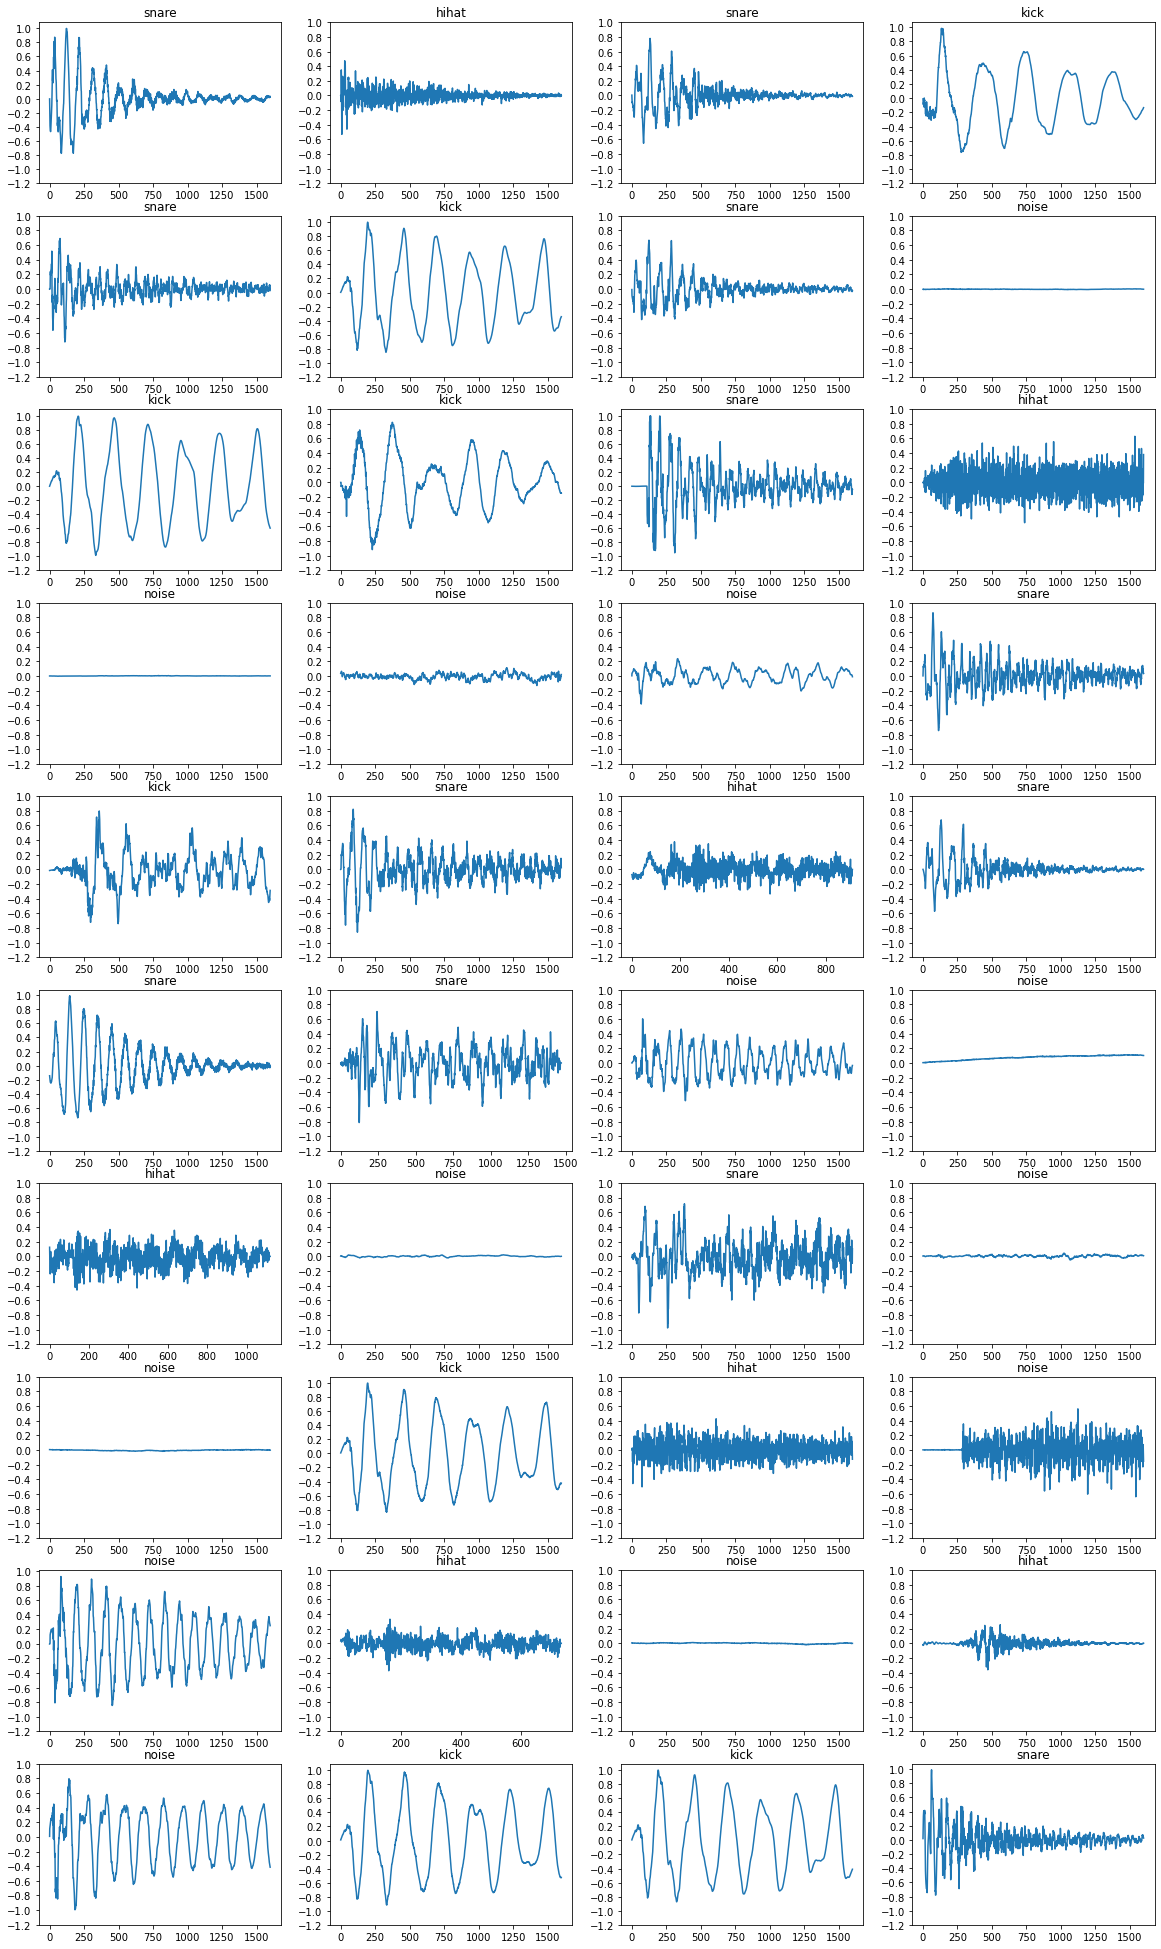

In [33]:
rows = 10
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 35))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

Você converterá a forma de onda em um espectrograma, que mostra as mudanças de frequência ao longo do tempo e pode ser representado como uma imagem 2D. Isso pode ser feito aplicando a transformada de Fourier de curta duração (STFT) para converter o áudio no domínio de tempo-frequência.

Uma transformada de Fourier (tf.signal.fft) converte um sinal para suas frequências componentes, mas perde todas as informações de tempo. O STFT (tf.signal.stft) divide o sinal em janelas de tempo e executa uma transformada de Fourier em cada janela, preservando algumas informações de tempo e retornando um tensor 2D no qual você pode executar convoluções padrão.

STFT produz uma matriz de números complexos representando magnitude e fase. No entanto, você só precisará da magnitude para este tutorial, que pode ser derivada aplicando tf.abs na saída de tf.signal.stft.

Escolha os parâmetros frame_length e frame_step de forma que a "imagem" do espectrograma gerado seja quase quadrada. Para mais informações sobre a escolha dos parâmetros STFT, você pode consultar este vídeo sobre processamento de sinal de áudio.

Você também deseja que as formas de onda tenham o mesmo comprimento, para que, ao convertê-las em uma imagem de espectrograma, os resultados tenham dimensões semelhantes. Isso pode ser feito simplesmente zerando os clipes de áudio com menos de um segundo.


In [71]:
def get_spectrogram(waveform):
  sample_size = 1600
  if len(waveform) > sample_size:  
    waveform = waveform[0:sample_size]
    equal_length = tf.concat([waveform[0:sample_size]], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=256, frame_step=128)
  else: 
    zero_padding = tf.zeros([sample_size] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128)

  spectrogram = tf.abs(spectrogram)
  return spectrogram

Em seguida, você explorará os dados. Compare a forma de onda, o espectrograma e o áudio real de um exemplo do conjunto de dados.

In [72]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: snare
Waveform shape: (1600, 1)
Spectrogram shape: (1600, 0, 129)
Audio playback


ValueError: too many values to unpack (expected 2)

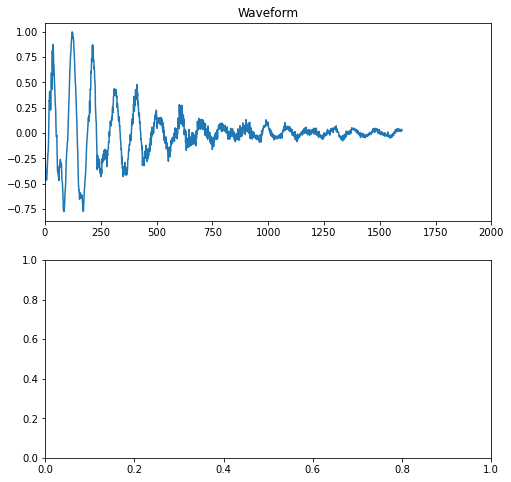

In [73]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(8, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 2000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [13]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == categories)
  return spectrogram, label_id

In [23]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

NameError: name 'plot_spectrogram' is not defined

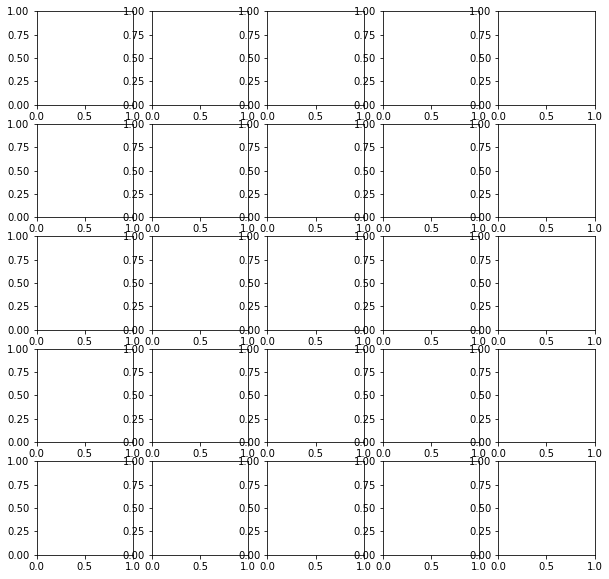

In [15]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(categories[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [ ]:
batch_size = 10
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(categories)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

model.save(filepath='./model')

Let's check the training and validation loss curves to see how your model has improved during training.

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

### Exibir uma matriz de confusão

Uma matriz de confusão é útil para ver o desempenho do modelo em cada um dos comandos do conjunto de teste.

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=categories, yticklabels=categories, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

In [ ]:
data_test_dir = pathlib.Path('./dataset/test')
# sample_file = data_test_dir/'kick/kick001.wav'
# sample_file = data_test_dir/'snare/snare001.wav'
# sample_file = data_test_dir/'hihat/hihat001.wav'
sample_file = data_test_dir/'noise/noise002.wav'

sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(categories, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{categories[label[0]]}"')
  plt.show()

## Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
